## 데이터 준비

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

In [2]:
from sklearn.datasets import load_boston
boston = load_boston()

df = pd.DataFrame(boston.data, columns=boston.feature_names)
df['TARGET'] = boston.target

In [3]:
scaler = StandardScaler()
scaler.fit(df.values[:,:-1])
df.values[:,:-1] = scaler.transform(df.values[:, :-1]).round(4)
df.tail()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,TARGET
501,-0.4132,-0.4877,0.1157,-0.2726,0.1581,0.4393,0.0187,-0.6258,-0.9828,-0.8032,1.1765,0.3872,-0.4181,22.4
502,-0.4152,-0.4877,0.1157,-0.2726,0.1581,-0.2345,0.2889,-0.7166,-0.9828,-0.8032,1.1765,0.4411,-0.5008,20.6
503,-0.4134,-0.4877,0.1157,-0.2726,0.1581,0.9850,0.7974,-0.7737,-0.9828,-0.8032,1.1765,0.4411,-0.9830,23.9
504,-0.4078,-0.4877,0.1157,-0.2726,0.1581,0.7257,0.7370,-0.6684,-0.9828,-0.8032,1.1765,0.4032,-0.8653,22.0
505,-0.4150,-0.4877,0.1157,-0.2726,0.1581,-0.3628,0.4347,-0.6132,-0.9828,-0.8032,1.1765,0.4411,-0.6691,11.9


- 정규화하기 전에 데이터셋 분포의 특징을 파악하고 어떤 정규화 방법이 가장 어울릴지 결정해야 한다.

## 학습 코드 구현

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [5]:
data = torch.from_numpy(df.values).float()

y = data[:, -1:]
x = data[:, :-1]

In [6]:
n_epochs = 200000
learning_rate = 1e-4
print_interval = 10000

In [7]:
class MyModel(nn.Module):

    def __init__(self, input_dim, output_dim):
        self.input_dim = input_dim
        self.output_dim = output_dim

        super().__init__()

        self.linear1 = nn.Linear(input_dim, 3)
        self.linear2 = nn.Linear(3,3)
        self.linear3 = nn.Linear(3,3)
        self.linear4 = nn.Linear(3, output_dim)
        self.act = nn.ReLU()

    def forward(self, x):
        h = self.act(self.linear1(x))
        h = self.act(self.linear2(h))
        h = self.act(self.linear3(h))
        y = self.linear4(h)

        return y

In [8]:
model = MyModel(x.size(-1), y.size(-1))
print(model)

MyModel(
  (linear1): Linear(in_features=13, out_features=3, bias=True)
  (linear2): Linear(in_features=3, out_features=3, bias=True)
  (linear3): Linear(in_features=3, out_features=3, bias=True)
  (linear4): Linear(in_features=3, out_features=1, bias=True)
  (act): ReLU()
)


In [9]:
model = nn.Sequential(
    nn.Linear(x.size(-1),3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3,3),
    nn.LeakyReLU(),
    nn.Linear(3, y.size(-1))
)
print(model)

Sequential(
  (0): Linear(in_features=13, out_features=3, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=3, out_features=3, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=3, out_features=3, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=3, out_features=3, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Linear(in_features=3, out_features=1, bias=True)
)


In [10]:
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [11]:
for i in range(n_epochs):
    y_hat = model(x)
    loss = F.mse_loss(y_hat, y)

    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

    if (i+1) % print_interval == 0:
        print('Epoch %d: loss=%.4e' % (i+1, loss))


Epoch 10000: loss=9.3254e+01
Epoch 20000: loss=8.4583e+01
Epoch 30000: loss=8.4424e+01
Epoch 40000: loss=8.4420e+01
Epoch 50000: loss=8.4420e+01
Epoch 60000: loss=8.4420e+01
Epoch 70000: loss=8.4420e+01
Epoch 80000: loss=8.4419e+01
Epoch 90000: loss=8.4419e+01
Epoch 100000: loss=8.4419e+01
Epoch 110000: loss=8.4419e+01
Epoch 120000: loss=8.4418e+01
Epoch 130000: loss=8.4418e+01
Epoch 140000: loss=8.4418e+01
Epoch 150000: loss=8.4417e+01
Epoch 160000: loss=8.4417e+01
Epoch 170000: loss=8.4417e+01
Epoch 180000: loss=8.4416e+01
Epoch 190000: loss=8.4415e+01
Epoch 200000: loss=8.4415e+01


## 결과 확인

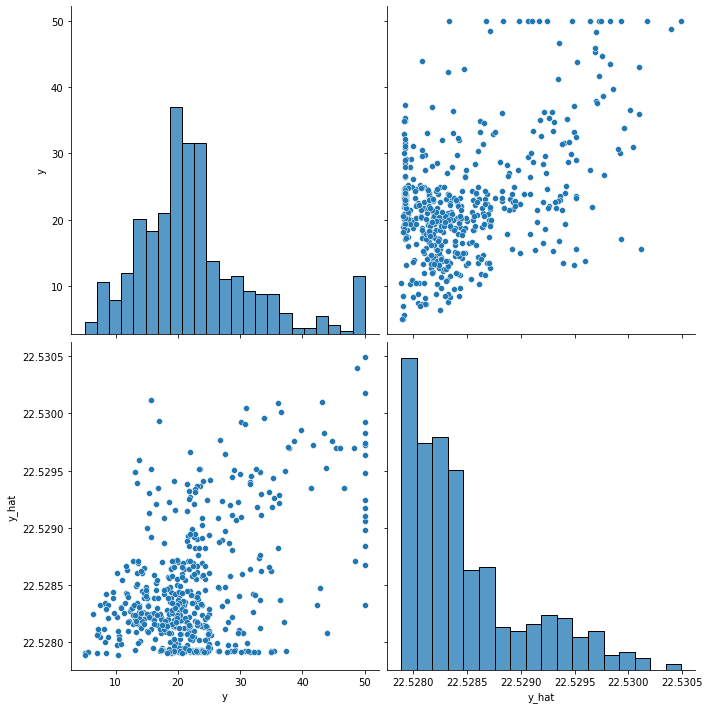

In [12]:
df = pd.DataFrame(torch.cat([y,y_hat], dim=1).detach().numpy(), columns=['y','y_hat'])
sns.pairplot(df, height=5)
plt.show()